# Phase 5: Machine Learning Model Training

In this notebook, we will:
1. Load the data (streaming source converted to batch for training).
2. Apply the feature engineering pipeline developed in Phase 4.
3. Train Machine Learning models (Random Forest, Gradient Boosting).
4. Evaluate model performance.
5. Save the best model for the real-time prediction pipeline.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, hour, dayofweek, from_unixtime
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("IoT Malware Detector - Model Training") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()

# Read from Kafka (Batch mode for Training)
# We use 'earliest' to 'latest' to get all available data in the topic
df_kafka = spark.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "big-data-final-project-kafka-1:29092") \
    .option("subscribe", "network-traffic") \
    .option("startingOffsets", "earliest") \
    .load()

print(f"Loaded {df_kafka.count()} records from Kafka.")

Loaded 156103 records from Kafka.


In [2]:
# Define Schema
schema = StructType([
    StructField("ts", DoubleType()),
    StructField("id.orig_h", StringType()),
    StructField("id.orig_p", DoubleType()),
    StructField("id.resp_h", StringType()),
    StructField("id.resp_p", DoubleType()),
    StructField("proto", StringType()),
    StructField("duration", StringType()),
    StructField("orig_bytes", StringType()),
    StructField("resp_bytes", StringType()),
    StructField("conn_state", StringType()),
    StructField("label", StringType()),
    StructField("detailed-label", StringType())
])

# Parse Data
df = df_kafka.selectExpr("CAST(value AS STRING) as json") \
    .select(from_json(col("json"), schema).alias("data")) \
    .select("data.*")

# Data Cleaning
df_cleaned = df.withColumn("duration", col("duration").cast("double")) \
    .withColumn("orig_bytes", col("orig_bytes").cast("long")) \
    .withColumn("resp_bytes", col("resp_bytes").cast("long")) \
    .withColumn("orig_port", col("`id.orig_p`").cast("int")) \
    .withColumn("resp_port", col("`id.resp_p`").cast("int")) \
    .fillna(0, subset=["duration", "orig_bytes", "resp_bytes"]) \
    .filter(col("label").isNotNull())

# Feature Extraction
df_features = df_cleaned.withColumn("timestamp", from_unixtime("ts").cast("timestamp")) \
    .withColumn("hour_of_day", hour("timestamp")) \
    .withColumn("day_of_week", dayofweek("timestamp")) \
    .withColumn("total_bytes", col("orig_bytes") + col("resp_bytes")) \
    .withColumn("bytes_per_sec", (col("orig_bytes") + col("resp_bytes")) / (col("duration") + 0.001))

# Feature Engineering Pipeline
indexer_proto = StringIndexer(inputCol="proto", outputCol="proto_index", handleInvalid="keep")
indexer_state = StringIndexer(inputCol="conn_state", outputCol="conn_state_index", handleInvalid="keep")
indexer_label = StringIndexer(inputCol="label", outputCol="label_index")

encoder = OneHotEncoder(inputCols=["proto_index", "conn_state_index"], 
                        outputCols=["proto_vec", "conn_state_vec"])

numerical_cols = ["duration", "orig_bytes", "resp_bytes", "orig_port", "resp_port", 
                  "total_bytes", "bytes_per_sec", "hour_of_day", "day_of_week"]
categorical_vecs = ["proto_vec", "conn_state_vec"]
assembler_inputs = numerical_cols + categorical_vecs

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

# Full Pipeline
pipeline = Pipeline(stages=[indexer_proto, indexer_state, indexer_label, encoder, assembler, scaler])

# Fit and Transform
model_pipeline = pipeline.fit(df_features)
df_final = model_pipeline.transform(df_features)

print("Data processed and features assembled.")
df_final.select("features", "label_index").show(5)

Data processed and features assembled.
+--------------------+-----------+
|            features|label_index|
+--------------------+-----------+
|[0.00207787375616...|        0.0|
|[-0.0102341131051...|        0.0|
|[0.00207314743094...|        0.0|
|[-0.0102341131051...|        0.0|
|[0.00206946820644...|        0.0|
+--------------------+-----------+
only showing top 5 rows



In [3]:
# Split Data
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)
print(f"Training Dataset Count: {train_data.count()}")
print(f"Test Dataset Count: {test_data.count()}")

# Train Random Forest Model
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features", numTrees=20)
rf_model = rf.fit(train_data)

print("Random Forest Model Trained.")

# Make Predictions
predictions = rf_model.transform(test_data)
predictions.select("label_index", "prediction", "probability").show(5)

Training Dataset Count: 124742
Test Dataset Count: 31361
Random Forest Model Trained.
+-----------+----------+--------------------+
|label_index|prediction|         probability|
+-----------+----------+--------------------+
|        1.0|       1.0|[0.19769228348195...|
|        0.0|       0.0|[0.99820771105647...|
|        0.0|       0.0|[0.99820771105647...|
|        0.0|       0.0|[0.99820771105647...|
|        0.0|       0.0|[0.99820771105647...|
+-----------+----------+--------------------+
only showing top 5 rows



Random Forest Accuracy: 0.9996811326169446
Random Forest F1 Score: 0.9996804815796546


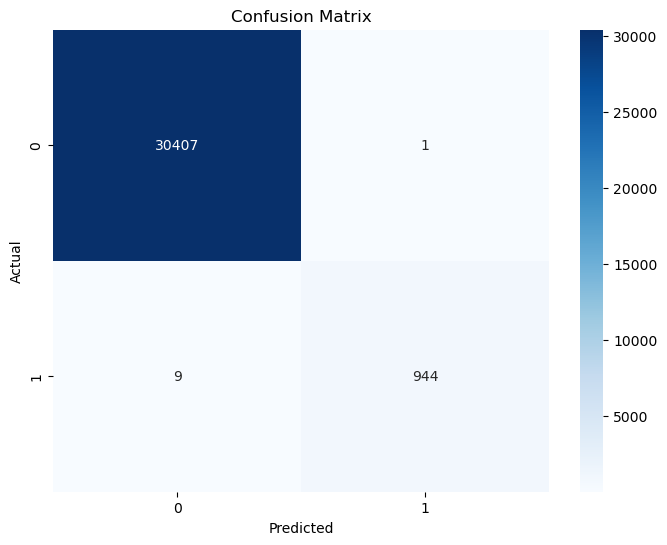

In [4]:
# Evaluate Model
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Random Forest Accuracy: {accuracy}")
print(f"Random Forest F1 Score: {f1_score}")

# Confusion Matrix (using pandas for display)
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_true = predictions.select("label_index").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# Train Gradient Boosting Model
gbt = GBTClassifier(labelCol="label_index", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)

print("Gradient Boosting Model Trained.")

# Make Predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate GBT
gbt_accuracy = evaluator_acc.evaluate(gbt_predictions)
gbt_f1 = evaluator_f1.evaluate(gbt_predictions)

print(f"GBT Accuracy: {gbt_accuracy}")
print(f"GBT F1 Score: {gbt_f1}")

Gradient Boosting Model Trained.
GBT Accuracy: 0.9999043397850834
GBT F1 Score: 0.9999043640799338


In [7]:
# Save the Best Model and Pipeline
# We will save the Random Forest model and the Feature Engineering Pipeline
import os

# Save the Classifier
model_path = "../models/rf_model"
rf_model.write().overwrite().save(model_path)
print(f"Random Forest Model saved to {model_path}")

# Save the Feature Engineering Pipeline
# Note: We need to be careful about the label indexer for production. 
# In production, we won't have the label column.
# We can save the whole pipeline, but when loading for inference, we might need to skip the label indexer stage.
pipeline_path = "../models/feature_pipeline"
model_pipeline.write().overwrite().save(pipeline_path)
print(f"Feature Pipeline saved to {pipeline_path}")

Random Forest Model saved to ../models/rf_model
Feature Pipeline saved to ../models/feature_pipeline
